<a href="https://colab.research.google.com/github/PeterTKovacs/mosquito_recoginition/blob/main/APRO_writeup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosquito recognition project

## project owner Csaba Tóth

### collaborator: Péter Kovács

Aedes albopictus (Stegomyia albopicta), from the mosquito (Culicidae) family, also known as (Asian) tiger mosquito or forest mosquito, is a mosquito native to the tropical and subtropical areas of Southeast Asia; however, in the past few decades, this species has spread to many countries through the transport of goods and international travel. It is characterized by the white bands on its legs and body.

This mosquito has become a significant pest in many communities because it closely associates with humans (rather than living in wetlands), and typically flies and feeds in the daytime in addition to at dusk and dawn. The insect is called a tiger mosquito for its striped appearance, which resembles that of the tiger. Ae. albopictus is an epidemiologically important vector for the transmission of many viral pathogens, including the yellow fever virus, dengue fever, and Chikungunya fever, as well as several filarial nematodes such as Dirofilaria immitis. Aedes albopictus is capable of hosting the Zika virus and is considered a potential vector for Zika transmission among humans.

source: https://en.wikipedia.org/wiki/Aedes_albopictus

This is a standard image classification challenge, where we need to build a classifier that can correctly decide if the presented image contains a tiger mosquito or not. Note, the data is coming from a citizen science project, so the data is not so high-quality and can be mislabeled!



In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
import torch
import shutil
import os
import random
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For the baseline model, we used a pretrained version of ResNet152. In the original dataset, there were five times as many tiger mosquitos as non-tiger mosquitoes, so we needed to partition the larger dataset into five smaller ones.

I have added some checkpointer functionality (for saving the current best model and then reloading it at the end).

This utility can be used to reload previously saved models without starting training in the current session. To this purpose, the model number is also required as input. __Important__: do not skip providing this, otherwise you may overwrite existing logs! Naming convention for logfiles is hard-coded into the class, so you can modify that there if you like.

Also amendeded _learning rate_ and _lr decay_ parameters for slower learining and more gradual LR decrease. (You may want to play with them too!)

In [ ]:
class BaseLine:
    def __init__(self,
        input_images_path_ = 'drive/My Drive/AML2020/images',
        csv_ = 'drive/My Drive/AML2020/train.csv',
        input_path_ = 'drive/My Drive/AML2020',
        train_path_ = 'drive/My Drive/AML2020/train4',
        test_path_ = 'drive/My Drive/AML2020/test',
        valid_path_ = 'drive/My Drive/AML2020/validation',
                no_=4):
        
        import torch
        import torchvision
        
        self.input_images_path = input_images_path_
        self.csv = csv_
        
        self.input_path = input_path_
        self.train_path = train_path_
        self.test_path = test_path_
        self.valid_path = valid_path_
        self.no=no_

    
    def folder_generator(self):
        import pandas as pd
        import logging as log
        import os
        
        csv_labels = pd.read_csv(self.csv)
        
        images_paths = list(csv_labels['file'])
        images_paths = [path.replace('images/', '') for path in images_paths]
        
        images_labels = list(csv_labels['is_tiger'])
        counter = 1
        
        tiger_path_train = os.path.join(self.train_path, 'tiger')
        not_tiger_path_train = os.path.join(self.train_path, 'not_tiger')
        
        tiger_path_val = os.path.join(self.valid_path, 'tiger')
        not_tiger_path_val = os.path.join(self.valid_path, 'not_tiger')
        
        test_unknown_path = os.path.join(self.test_path, 'unknown')
        
        os.mkdir(self.train_path)
        os.mkdir(tiger_path_train)
        os.mkdir(not_tiger_path_train)

        os.mkdir(self.valid_path)
        os.mkdir(tiger_path_val)
        os.mkdir(not_tiger_path_val)
        
        os.mkdir(self.test_path)
        os.mkdir(test_unknown_path)
        
        #Handling Train Images
        print('###Handling Train Images')
        for image_name, image_label in zip(images_paths, images_labels):
            print('Copying image: {}, with label: {}'.format(image_name, image_label))    
            if image_name.split('_')[0] == 'train' and counter % 5 != 0:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_train))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_train))
            else:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_val))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_val))
            
    
    def data_loader(self):
        import torch
        import torchvision
        from torchvision import transforms
        
        #ImageFolder
        #Augementation for train and valid images
        
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        train_dataset = torchvision.datasets.ImageFolder(self.train_path, train_transforms)
        validation_dataset = torchvision.datasets.ImageFolder(self.valid_path, val_transforms)
        
        #DataLoader
        batch_size = 16
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )

        validation_dataloader = torch.utils.data.DataLoader(
            validation_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )
        print(len(train_dataset), len(validation_dataset))
        print(len(train_dataloader), len(validation_dataloader))
        return train_dataloader, validation_dataloader
    
    def show_images(self, train_dataloader):
        
        import numpy as np
        import matplotlib.pyplot as plt
        X_batch, y_batch = next(iter(train_dataloader))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([[0.229, 0.224, 0.225]])
        for index in range(5):
            plt.title(y_batch[index])
            plt.imshow(X_batch[index].permute(1,2,0).numpy() * std + mean, )
            plt.show()
    
    def model(self):
        from torchvision import models
        import torch
        model = models.resnet152(pretrained=True) # orginally False - why???
        
        #Disable grad for all conv layers
        for param in model.parameters():
            param.requires_grad = False 

        model.fc = torch.nn.Linear(model.fc.in_features, 2)
       
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        
        loss = torch.nn.CrossEntropyLoss() # deleted crossentropy loss weigths

        
        optimizer = torch.optim.Adam(model.parameters(),amsgrad=True, lr=5.0e-4) # divided LR by two
       
        
        #Declay LR by a factor of 0.1 every 5th epoch
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5) # gamma to five times
        return model, loss, optimizer, scheduler, device
    
    def train_model(self, model, loss, optimizer, scheduler, train, validation, device, num_epochs):
        import torch
        from tqdm import tqdm
        
        best_accuracy=-1
        best_path='best'+str(self.no)+'.pth'
        
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train
                    scheduler.step()
                    
                    model.train()  # Set model to training mode
                else:
                    dataloader = validation
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.
                running_acc = 0.

                # Iterate over data.
                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward and backward
                    with torch.set_grad_enabled(phase == 'train'):                     
                        
                        preds = model(inputs).to(device)

                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
                
                if epoch_acc>best_accuracy and phase=='val' :
                    
                    self.create_checkpoint(model,optimizer,best_path,epoch,loss_value)
                    best_accuracy=epoch_acc
        
        
        self.load_from_checkpoint(model,optimizer,best_path)

        return model
    
    def create_checkpoint(self,model,optimizer,path,epoch,loss):
        
        # basically copied from the tutorial, 
        # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
        
    def load_from_checkpoint(self,model,optimizer,path):
        
        # basically copied from the tutorial, 
        # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
        
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        print('reloading best model of epoch %d, loss %f'%(checkpoint['epoch'],checkpoint['loss']))
        
    def run(self,num_ep=10):

        train_dataloader, validation_dataloader = self.data_loader()
        
        #Define model
        
        model, loss, optimizer, scheduler, device = self.model()

        #Train model 
        
        trained_model = self.train_model(model, loss, optimizer, scheduler, train_dataloader, validation_dataloader,
                                         device, num_epochs=num_ep)
        return trained_model

In [ ]:
model = BaseLine().run()

1132 855
71 54
Epoch 0/9:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 71/71 [00:55<00:00,  1.28it/s]

train Loss: 0.6473 Acc: 0.6247



100%|██████████| 54/54 [00:18<00:00,  2.93it/s]

val Loss: 0.4624 Acc: 0.8322


Epoch 1/9:


100%|██████████| 71/71 [00:25<00:00,  2.77it/s]

train Loss: 0.5286 Acc: 0.7441



100%|██████████| 54/54 [00:18<00:00,  2.90it/s]

val Loss: 0.3968 Acc: 0.8643


Epoch 2/9:


100%|██████████| 71/71 [00:25<00:00,  2.83it/s]

train Loss: 0.4683 Acc: 0.8037



100%|██████████| 54/54 [00:18<00:00,  2.86it/s]

val Loss: 0.4860 Acc: 0.7867
Epoch 3/9:



100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.4565 Acc: 0.8016



100%|██████████| 54/54 [00:18<00:00,  2.91it/s]

val Loss: 0.4577 Acc: 0.8029
Epoch 4/9:



100%|██████████| 71/71 [00:25<00:00,  2.79it/s]

train Loss: 0.4469 Acc: 0.8060



100%|██████████| 54/54 [00:18<00:00,  2.92it/s]

val Loss: 0.3451 Acc: 0.8704


Epoch 5/9:


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4383 Acc: 0.7975



100%|██████████| 54/54 [00:18<00:00,  2.89it/s]

val Loss: 0.3714 Acc: 0.8562
Epoch 6/9:



100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4380 Acc: 0.7952



100%|██████████| 54/54 [00:18<00:00,  2.90it/s]

val Loss: 0.3678 Acc: 0.8507
Epoch 7/9:



100%|██████████| 71/71 [00:25<00:00,  2.79it/s]

train Loss: 0.4377 Acc: 0.8148



100%|██████████| 54/54 [00:18<00:00,  2.89it/s]

val Loss: 0.4068 Acc: 0.8318
Epoch 8/9:



100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.4207 Acc: 0.8330



100%|██████████| 54/54 [00:18<00:00,  2.90it/s]

val Loss: 0.3547 Acc: 0.8623
Epoch 9/9:



100%|██████████| 71/71 [00:25<00:00,  2.77it/s]

train Loss: 0.4255 Acc: 0.8166



100%|██████████| 54/54 [00:18<00:00,  2.91it/s]

val Loss: 0.3783 Acc: 0.8495


reloading best model of epoch 4, loss 0.134331


# training

Just made auxiliary functions for training the five models.

__Directory structure was made before this part__ (not contained in the notebook)

Generally speaking, inside _train_ and _valid_ directories, there are _m0_,...,_m4_ directories fed into the dataloader machinery. (So with _./tiger_ and _./other_ subdirectories inside.

In [ ]:
def model_(n,basedir='drive/My Drive/AML2020/'):
    
    
    
    model=BaseLine(
    train_path_=os.path.join(basedir,'train'+str(n)+'/'),
    valid_path_=os.path.join(basedir,'validation/'),
    test_path_=os.path.join(basedir,'test/'),
    no_=n)
    
    return model

As I did training before, I just load the model from the saved logs. (Each net eats up roughly 250 MB)

The trick is to use the training machinery that reloads the best model at the end: if you set the epoch number to 0 then it will only do this.

__Important__: the naming convention of logfiles in hard-coded into the BaseLine class definition, you only access the number of the model (0,...,4) from outside.



In [ ]:
models={}
for i in range(5):
    m=model_(i)
    trained_m=m.run(num_ep=0)
    models[i]=trained_m

1136 855
71 54
reloading best model of epoch 6, loss 0.239484
1132 855
71 54
reloading best model of epoch 0, loss 0.307845
1132 855
71 54
reloading best model of epoch 4, loss 0.331140
1132 855
71 54
reloading best model of epoch 2, loss 0.262762
1132 855
71 54
reloading best model of epoch 4, loss 0.134331


# testing pipeline

Assuming that you have trained all the models, their performance should be assessed and compared to each other

This is fairly simple but requires getting hands dirty with code. To save time, I hereby present the pipeline I wrote. You may use it or write a different one.

In [ ]:
import pandas as pd

In [ ]:
import pickle

Conversion of model output (unactivated stuff) to confidency scores (auxiliary functions below)

In [ ]:
def softmax(tensor):
    
    z=np.sum(np.exp(np.asarray(tensor)))
    
    return np.exp(np.asarray(tensor))/z
    

In [ ]:
def confidency(preds):
    
    confidencies=[]
    
    for pic in range(preds.shape[0]):
        
        confidencies.append(softmax(preds[pic,:])[1]) # guess that this is the tiger probability
        
    return confidencies
        

The actual pipe, consisting of evaluating predictions on the test images in batches.

All models are loaded into memory and then set to _evaluate_ mode.

Results are stored in dictionary format: (model:(image_name:condfidency)). 

In [ ]:
test_other_names=os.listdir('drive/My Drive/AML2020/validation/not_tiger')
test_tiger_names=random.sample(os.listdir('drive/My Drive/AML2020/validation/tiger'),len(test_other_names))


In [ ]:
batch_size=10
counter=0
to_batch=[]
results={}

val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

for id_,model in models.items():
    results[id_]={}
    model.eval()

for pic in test_other_names:
    to_batch.append((pic,val_transforms(Image.open('drive/My Drive/AML2020/validation/not_tiger/'+pic))))
    counter+=1
    
    if counter==batch_size:
        
        batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
        for id_,model in models.items():
            
            conf=confidency(model(batch).cpu().detach().numpy())
            
            for idx,item in enumerate(to_batch):
            
                results[id_][item[0]]=conf[idx]
                
        counter=0
        to_batch=[]
        
for pic in test_tiger_names:
    to_batch.append((pic,val_transforms(Image.open('drive/My Drive/AML2020/validation/tiger/'+pic))))
    counter+=1
    
    if counter==batch_size:
        
        batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
        for id_,model in models.items():
            
            conf=confidency(model(batch).cpu().detach().numpy())
            
            for idx,item in enumerate(to_batch):
            
                results[id_][item[0]]=conf[idx]
                
        counter=0
        to_batch=[]
    
            
if len(to_batch)>0: #some pics remained unevaluated
    
    batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
    for id_,model in models.items():

        conf=confidency(model(batch).cpu().detach().numpy())

        for idx,item in enumerate(to_batch):

            results[id_][item[0]]=conf[idx]

    counter=0
    to_batch=[]
        
    

Saving the results to file (safety is the best)

In [ ]:
f=open('results_dictionary.txt','wb')

In [ ]:
pickle.dump(results,f)

In [ ]:
import copy

In [ ]:
rr=copy.deepcopy(results)

In [ ]:
for idx,model in models.items():
    for key,value in rr[idx].items():
        rr[idx][key]=list([value,])

In [ ]:
tabular_res=pd.concat([pd.DataFrame.from_dict(rr[i]) for i in range(5)])

In [ ]:
tabular_res

,train_14.png,train_24.png,train_49.png,train_104.png,train_199.png,train_244.png,train_249.png,train_314.png,train_364.png,train_384.png,train_394.png,train_424.png,train_474.png,train_479.png,train_529.png,train_534.png,train_539.png,train_659.png,train_719.png,train_724.png,train_789.png,train_834.png,train_869.png,train_1004.png,train_1029.png,train_1034.png,train_1079.png,train_1084.png,train_1109.png,train_1124.png,train_1134.png,train_1139.png,train_1149.png,train_1179.png,train_1189.png,train_1229.png,train_1294.png,train_1299.png,train_1309.png,train_1339.png,...,train_2754.png,train_3924.png,train_1064.png,train_369.png,train_99.png,train_1279.png,train_2869.png,train_269.png,train_3434.png,train_299.png,train_504.png,train_3014.png,train_4064.png,train_3299.png,train_294.png,train_1919.png,train_2019.png,train_2899.png,train_1689.png,train_1074.png,train_374.png,train_3274.png,train_1504.png,train_1329.png,train_1344.png,train_1369.png,train_359.png,train_2849.png,train_1184.png,train_2539.png,train_939.png,train_3439.png,train_2304.png,train_3119.png,train_2854.png,train_4229.png,train_4099.png,train_2804.png,train_3129.png,train_974.png
0,0.107681,0.118576,0.307205,0.689934,0.316198,0.155378,0.369547,0.635186,0.030643,0.203867,0.204302,0.590388,0.607434,0.543216,0.730225,0.147817,0.388529,0.201687,0.128747,0.400193,0.217765,0.212508,0.215102,0.378922,0.163254,0.403458,0.303551,0.507916,0.244593,0.187505,0.255707,0.260125,0.271791,0.146058,0.120789,0.602385,0.676812,0.660993,0.198405,0.774465,...,0.946308,0.819098,0.947360,0.780192,0.852264,0.970319,0.592115,0.476474,0.986848,0.947423,0.958903,0.822827,0.715206,0.960530,0.938153,0.797133,0.823967,0.777626,0.966122,0.896629,0.528489,0.744755,0.813760,0.921532,0.959988,0.907696,0.610791,0.297538,0.970637,0.960219,0.903883,0.862044,0.757528,0.857608,0.916907,0.837021,0.781336,0.713476,0.858478,0.641163
0,0.420940,0.394472,0.379758,0.682251,0.468832,0.349968,0.538410,0.731527,0.196723,0.360970,0.353495,0.643676,0.784692,0.675286,0.734843,0.296442,0.468672,0.350488,0.331957,0.459162,0.310106,0.540449,0.471911,0.727447,0.302009,0.593067,0.587883,0.529311,0.329918,0.403243,0.484306,0.397164,0.603867,0.309707,0.309155,0.627196,0.675238,0.776963,0.404986,0.854346,...,0.866288,0.698266,0.806380,0.620806,0.762998,0.930440,0.593610,0.646470,0.899994,0.915341,0.834770,0.784573,0.810953,0.886081,0.853722,0.714794,0.725281,0.749814,0.879884,0.821279,0.599326,0.752993,0.821501,0.863327,0.904263,0.808219,0.742848,0.413653,0.890535,0.880727,0.875983,0.773946,0.673736,0.747381,0.828842,0.797135,0.671830,0.536919,0.749276,0.696749
0,0.091365,0.153782,0.278223,0.637312,0.301948,0.159006,0.135537,0.463947,0.039325,0.273761,0.241501,0.530619,0.470568,0.426249,0.607450,0.135503,0.371328,0.175916,0.108274,0.247129,0.157867,0.287235,0.170319,0.680589,0.111854,0.217475,0.390770,0.378951,0.120014,0.166899,0.241401,0.170561,0.230030,0.122516,0.078293,0.499613,0.671416,0.621704,0.113886,0.747547,...,0.937460,0.660475,0.957991,0.728826,0.790803,0.967019,0.545359,0.394855,0.957055,0.952759,0.936032,0.785173,0.727683,0.940380,0.885184,0.719116,0.704574,0.839533,0.914936,0.788935,0.604712,0.687646,0.763703,0.856038,0.947703,0.888240,0.650079,0.288112,0.965705,0.950123,0.898418,0.890343,0.622189,0.793491,0.922529,0.813897,0.718049,0.649302,0.855516,0.497211
0,0.124531,0.173273,0.297116,0.794334,0.331597,0.235182,0.186632,0.458872,0.055754,0.376725,0.325257,0.517941,0.690262,0.472052,0.617346,0.173292,0.252825,0.229967,0.177500,0.223885,0.194014,0.303539,0.299027,0.600088,0.144377,0.347030,0.380232,0.376106,0.111142,0.271766,0.193024,0.290081,0.239091,0.186248,0.181424,0.698912,0.668221,0.595645,0.188520,0.742117,...,0.930173,0.752361,0.949720,0.703973,0.878949,0.980203,0.596228,0.493863,0.967554,0.942768,0.912720,0.672722,0.815762,0.928429,0.894401,0.779206,0.807829,0.680214,0.929477,0.665337,0.546577,0.772685,0.813597,0.908839,0.965391,0.830084,0.575911,0.216088,0.953727,0.928157,0.925784,0.862301,

In [ ]:
tabular_res.index=[0,1,2,3,4]

In [ ]:
data=tabular_res.transpose()

In [ ]:
data.head()

,0,1,2,3,4
train_14.png,0.107681,0.420940,0.091365,0.124531,0.153208
train_24.png,0.118576,0.394472,0.153782,0.173273,0.200241
train_49.png,0.307205,0.379758,0.278223,0.297116,0.320627
train_104.png,0.689934,0.682251,0.637312,0.794334,0.707619
train_199.png,0.316198,0.468832,0.301948,0.331597,0.382740


# Evaluation

This is the part what I just started to extract some impressions. 

What seems:

+ The predicted confidency scores are very much correlated (not surprisingly)
+ As you approach the average 0.5 'threshold', the predictions become more scattered and less correlated
    + Hence we may use our 5 models in this regime as an utiliy embedding pictures into a 5D space. Then the task would be building a classifier on this data. (like the PB dataset)
        + consider: selecting the appropriate regime (maybe near 0.5)
        + maybe not all nets shall have same voting power?
        + evaluate the performance of the 5D classifier on BALANCED test set!

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data.corr()

,0,1,2,3,4
0,1.000000,0.949851,0.971146,0.965335,0.971266
1,0.949851,1.000000,0.937367,0.942567,0.939843
2,0.971146,0.937367,1.000000,0.962071,0.968139
3,0.965335,0.942567,0.962071,1.000000,0.963625
4,0.971266,0.939843,0.968139,0.963625,1.000000


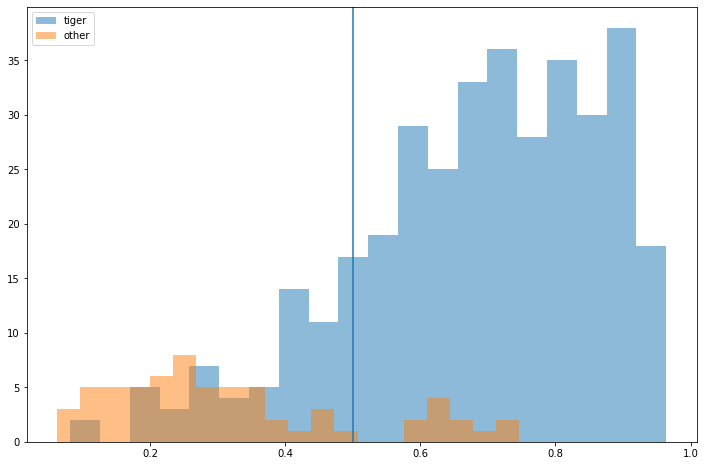

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(data.loc[test_tiger_names,:].mean(axis=1),bins=20,label='tiger',alpha=0.5)
plt.hist(data.loc[test_other_names,:].mean(axis=1),bins=20,label='other',alpha=0.5)
plt.axvline(0.5)
plt.legend()
plt.show()

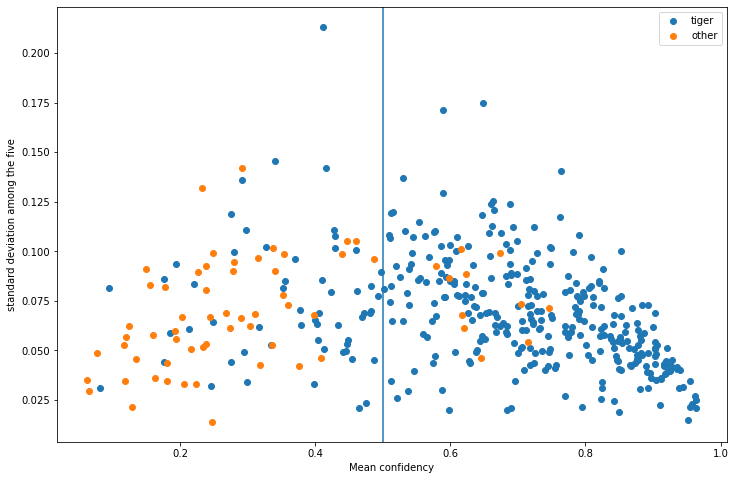

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(data.loc[test_tiger_names,:].mean(axis=1),
             data.loc[test_tiger_names,:].std(axis=1),label='tiger')
plt.scatter(data.loc[test_other_names,:].mean(axis=1),
            data.loc[test_other_names,:].std(axis=1),label='other')
plt.axvline(0.5)
plt.xlabel('Mean confidency')
plt.ylabel('standard deviation among the five')
plt.legend()
plt.show()

The below 'cross' plots are only to get some feeling of the _order_ of points that may be 'saved' with a better 5D classifier.

(Eg. the ones for which the minimal and maximal confidency score would imply different predicted classes. This is only a rough estimate of course.)

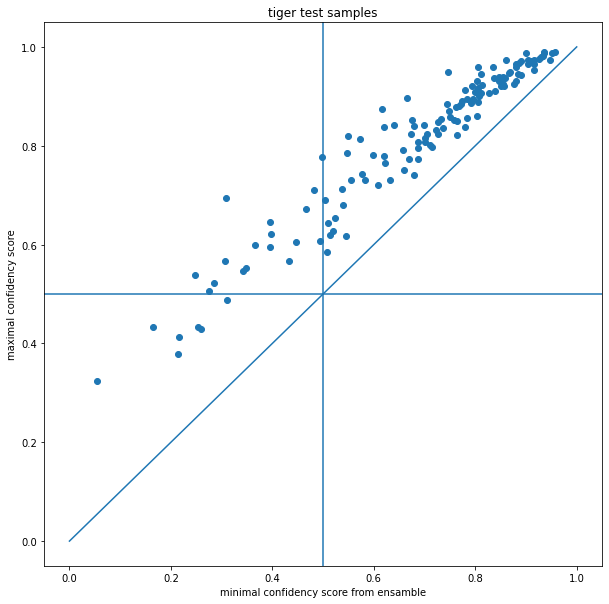

In [ ]:
plt.figure(figsize=(10,10))
plt.title('tiger test samples')
plt.scatter(data.loc[test_tiger_names,:].min(axis=1),
             data.loc[test_tiger_names,:].max(axis=1),label='tiger')
# plt.scatter(data.loc[test_other_names,:].min(axis=1),
#             data.loc[test_other_names,:].max(axis=1),label='other')
plt.xlabel('minimal confidency score from ensamble')
plt.ylabel('maximal confidency score')
plt.plot([0,1],[0,1])
plt.axvline(0.5)
plt.axhline(0.5)
# plt.legend()
plt.show()

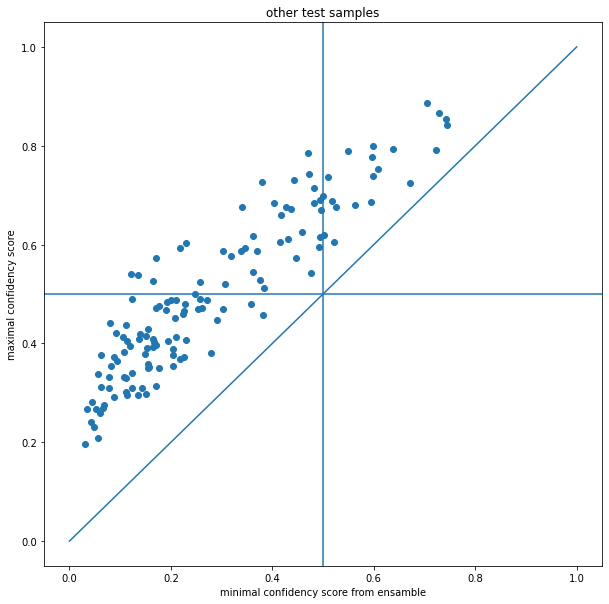

In [ ]:
plt.figure(figsize=(10,10))
plt.title('other test samples')
# plt.scatter(data.loc[test_tiger_names,:].min(axis=1),
#              data.loc[test_tiger_names,:].max(axis=1),label='tiger')
plt.scatter(data.loc[test_other_names,:].min(axis=1),
            data.loc[test_other_names,:].max(axis=1),label='other')
plt.xlabel('minimal confidency score from ensamble')
plt.ylabel('maximal confidency score')
plt.plot([0,1],[0,1])
plt.axvline(0.5)
plt.axhline(0.5)
# plt.legend()
plt.show()

In [ ]:
ahead_redemption=data[np.abs(0.5-data.mean(axis=1))<0.2]

In [ ]:
ahead_redemption.corr() # this is the part what matters - much weaker correlations!

,0,1,2,3,4
0,1.000000,0.700974,0.821353,0.795057,0.806789
1,0.700974,1.000000,0.613815,0.708974,0.646135
2,0.821353,0.613815,1.000000,0.761456,0.771120
3,0.795057,0.708974,0.761456,1.000000,0.780679
4,0.806789,0.646135,0.771120,0.780679,1.000000


In [ ]:
tiger_data=data.loc[test_tiger_names,:]
other_data=data.loc[test_other_names,:]

In [ ]:
id1=3
id2=1

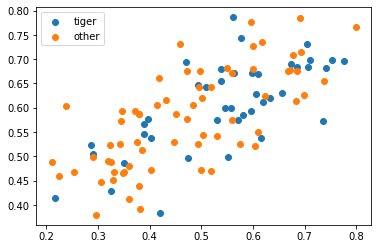

In [ ]:
plt.figure()
plt.scatter(tiger_data[np.abs(0.5-tiger_data.mean(axis=1))<0.2][id1],
           tiger_data[np.abs(0.5-tiger_data.mean(axis=1))<0.2][id2],label='tiger')
plt.scatter(other_data[np.abs(0.5-other_data.mean(axis=1))<0.2][id1],
           other_data[np.abs(0.5-other_data.mean(axis=1))<0.2][id2],label='other')
plt.legend()

According to these evaluations, the next step is to do a 5-dimensional regression on the output of the five models. Note, that each model outputs a confidency score between 0 and 1 for each image (1 means that the model has full confidency that the image containts a tiger mosquito).

The three regression models we used are Logistic regression, Support Vector Machine, and Decision tree.

First, we construct the Majority Vote of the 5 models.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import svm


labels = pd.read_csv('drive/My Drive/AML2020/train.csv')
indeces = []
for pic in list(data.index):
    index = list(labels['file']).index('images/'+pic)
    indeces.append(index)

labels_data = labels.iloc[indeces]
data['labels'] = list(labels_data['is_tiger'])

X, y = data[[0,1,2,3,4]], data['labels'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

a0_train = np.reshape(X_train[0].to_numpy(),(-1,1))
a0_test = np.reshape(X_test[0].to_numpy(),(-1,1))
clf_0 = tree.DecisionTreeClassifier().fit(a0_train,y_train)
X_test['dt0'] = clf_0.predict(a0_test)
a1_train = np.reshape(X_train[1].to_numpy(),(-1,1))
a1_test = np.reshape(X_test[1].to_numpy(),(-1,1))
clf_1 = tree.DecisionTreeClassifier().fit(a1_train,y_train)
X_test['dt1'] = clf_1.predict(a1_test)
a2_train = np.reshape(X_train[2].to_numpy(),(-1,1))
a2_test = np.reshape(X_test[2].to_numpy(),(-1,1))
clf_2 = tree.DecisionTreeClassifier().fit(a2_train,y_train)
X_test['dt2'] = clf_2.predict(a2_test)
a3_train = np.reshape(X_train[3].to_numpy(),(-1,1))
a3_test = np.reshape(X_test[3].to_numpy(),(-1,1))
clf_3 = tree.DecisionTreeClassifier().fit(a3_train,y_train)
X_test['dt3'] = clf_3.predict(a3_test)
a4_train = np.reshape(X_train[4].to_numpy(),(-1,1))
a4_test = np.reshape(X_test[4].to_numpy(),(-1,1))
clf_4 = tree.DecisionTreeClassifier().fit(a4_train,y_train)
X_test['dt4'] = clf_4.predict(a4_test)

In [ ]:
X_test['MV'] = round((X_test['dt0']+X_test['dt1']+X_test['dt2']+X_test['dt3']+X_test['dt4'])/5)

In [ ]:
data[0].round()

train_14.png      0.0
train_24.png      0.0
train_49.png      0.0
train_104.png     1.0
train_199.png     0.0
                 ... 
train_4229.png    1.0
train_4099.png    1.0
train_2804.png    1.0
train_3129.png    1.0
train_974.png     1.0
Name: 0, Length: 272, dtype: float64

Define the accuracies of the Majority vote.

In [ ]:
mv_acc = sum(1 for x,y in zip(X_test['MV'],y_test) if x == y) / len(y_test)
mv_acc_tiger = sum(1 for x,y in zip(X_test['MV'],y_test) if x == 1 == y ) / sum(y_test)
mv_acc_not_tiger = sum(1 for x,y in zip(X_test['MV'],y_test) if x == 0 == y) / (len(y_test) - sum(y_test))

Define the accuracies of the best model.

In [ ]:
model_acc0 = sum(1 for x,y in zip(data[0].round(),data['labels']) if x == y) / len(data)
model_acc1 = sum(1 for x,y in zip(data[1].round(),data['labels']) if x == y) / len(data)
model_acc2 = sum(1 for x,y in zip(data[2].round(),data['labels']) if x == y) / len(data)
model_acc3 = sum(1 for x,y in zip(data[3].round(),data['labels']) if x == y) / len(data)
model_acc4 = sum(1 for x,y in zip(data[4].round(),data['labels']) if x == y) / len(data)
print(model_acc0,model_acc1,model_acc2,model_acc3,model_acc4)

0.8014705882352942 0.7647058823529411 0.8235294117647058 0.8235294117647058 0.8088235294117647


In [ ]:
mv4_acc_tiger = sum(1 for x,y in zip(data[3].round(),data['labels']) if x == 1 == y ) / sum(data['labels'])
mv4_acc_not_tiger = sum(1 for x,y in zip(data[3].round(),data['labels']) if x == 0 == y) / (len(data) - sum(data['labels']))


In [ ]:
weights_tiger=[]
weights_not_tiger=[]
#for i in range(len(data)):
  #if data['labels'][i] == 1:
    #weights_not_tiger.append(0)
    #weights_tiger.append(1/(sum(data['labels'])))
  #else:
    #weights_not_tiger.append(1/(len(data) - sum(data['labels'])))
    #weights_tiger.append(0)
for i in range(len(X_test)):
  if y_test[i] == 1:
    weights_not_tiger.append(0)
    weights_tiger.append(1/(sum(y_test)))
  else:
    weights_not_tiger.append(1/(len(X_test) - sum(y_test)))
    weights_tiger.append(0)

The three regression models we used: Logistic regression, Decision tree and Support Vector Machine.

In [ ]:
X, y = data[[0,1,2,3,4]], data['labels'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train,y_train)
clf2 = svm.SVC().fit(X_train,y_train)
clf3 = tree.DecisionTreeClassifier().fit(X_train,y_train)

Put the accuracies in a Dataframe.

In [ ]:
results = pd.DataFrame()
results['Overall Accuracy'] = [clf.score(X_test,y_test),clf2.score(X_test,y_test),clf3.score(X_test,y_test),mv_acc,model_acc3]
results['Tiger Accuracy'] = [clf.score(X_test,y_test,sample_weight=weights_tiger),clf2.score(X_test,y_test,sample_weight=weights_tiger),clf3.score(X_test,y_test,sample_weight=weights_tiger),mv_acc_tiger,mv4_acc_tiger]
results['Non-tiger Accuracy'] = [clf.score(X_test,y_test,sample_weight=weights_not_tiger),clf2.score(X_test,y_test,sample_weight=weights_not_tiger),clf3.score(X_test,y_test,sample_weight=weights_not_tiger),mv_acc_not_tiger,mv4_acc_not_tiger]
results.index = ['LogReg','SVM','DT','Majority','Best model']
results = results.sort_values('Overall Accuracy')
results

,Overall Accuracy,Tiger Accuracy,Non-tiger Accuracy
DT,0.755556,0.731707,0.775510
Majority,0.811111,0.780488,0.836735
Best model,0.823529,0.882353,0.764706
LogReg,0.855556,0.829268,0.877551
SVM,0.877778,0.804878,0.938776


Graph the results.

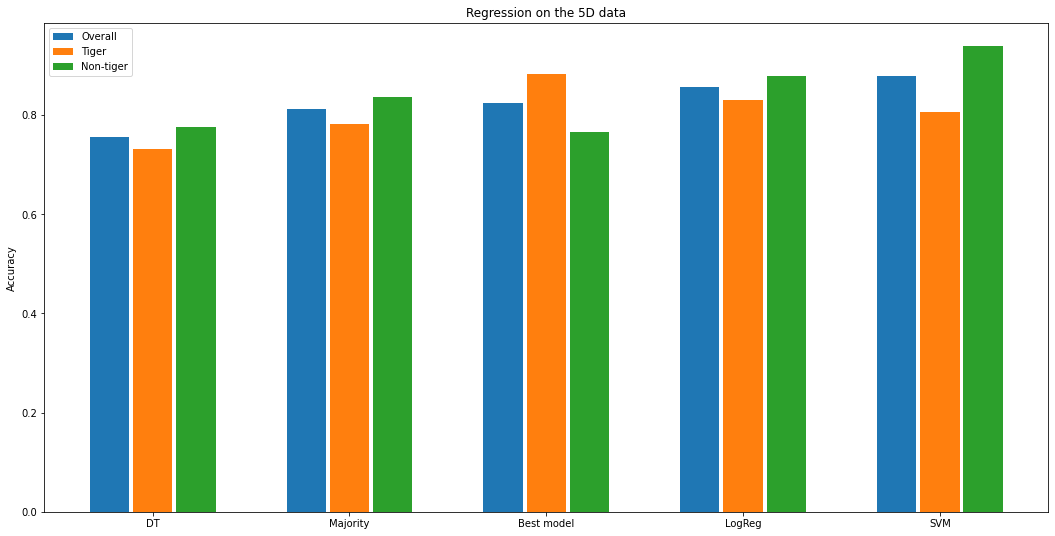

In [ ]:
import matplotlib.pyplot as plt
labels = results.index


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(18,9))
rects1 = ax.bar(x - 1.1*width, results['Overall Accuracy'], width, label='Overall')
rects2 = ax.bar(x, results['Tiger Accuracy'], width, label='Tiger')
rects3 = ax.bar(x + 1.1*width, results['Non-tiger Accuracy'], width, label='Non-tiger')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Regression on the 5D data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()